# <font color='blue'>Séries Temporais</font>

In [1]:
# Imports para manipulação de dados
import pandas as pd
import numpy as np

# Imports para visualização de dados
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as m
import seaborn as sns

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtra os warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
Dando os devidos créditos:
Esta função foi recebida no curso de Modelagem de Séries Temporais e Real-Time Analytics 
com Apache Spark e Databricks oferecido pela DSA - Data Science Academy
'''

# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

In [3]:
# Formatação para os gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Formatando os labels dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [5]:
# Carregando os dados
dados =pd.read_csv('../datasets/acidentes_dia.csv', 
                    header = None, 
                   index_col = 0,
                    names = ['qtd_acidentes'])

In [6]:
# Visualizando os Dados
dados.head()

,qtd_acidentes
2015-06-01,6
2015-06-02,8
2015-06-03,7
2015-06-04,4
2015-06-05,12


In [7]:
# Informações gerais do arquivo
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3454 entries, 2015-06-01 to 2024-12-28
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   qtd_acidentes  3454 non-null   int64
dtypes: int64(1)
memory usage: 54.0+ KB


In [8]:
dados.index = pd.to_datetime(dados.index, format="%Y-%m-%d")

In [9]:
# Informações gerais do arquivo
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3454 entries, 2015-06-01 to 2024-12-28
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   qtd_acidentes  3454 non-null   int64
dtypes: int64(1)
memory usage: 54.0 KB


In [10]:
# Resumo estatístico
dados.describe()

,qtd_acidentes
count,3454.000000
mean,7.916039
std,4.568292
min,0.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,31.000000


In [11]:
inicio = dados.index.max() + pd.Timedelta(days=1)
final = inicio + pd.Timedelta(days=30)
novos_dados = pd.Series(index=pd.date_range(start=inicio, end=final, freq='D'))
novos_dados

2024-12-29   NaN
2024-12-30   NaN
2024-12-31   NaN
2025-01-01   NaN
2025-01-02   NaN
2025-01-03   NaN
2025-01-04   NaN
2025-01-05   NaN
2025-01-06   NaN
2025-01-07   NaN
2025-01-08   NaN
2025-01-09   NaN
2025-01-10   NaN
2025-01-11   NaN
2025-01-12   NaN
2025-01-13   NaN
2025-01-14   NaN
2025-01-15   NaN
2025-01-16   NaN
2025-01-17   NaN
2025-01-18   NaN
2025-01-19   NaN
2025-01-20   NaN
2025-01-21   NaN
2025-01-22   NaN
2025-01-23   NaN
2025-01-24   NaN
2025-01-25   NaN
2025-01-26   NaN
2025-01-27   NaN
2025-01-28   NaN
Freq: D, dtype: float64

In [12]:
dados = dados.resample('D').sum()

In [13]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3499 entries, 2015-06-01 to 2024-12-28
Freq: D
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   qtd_acidentes  3499 non-null   int64
dtypes: int64(1)
memory usage: 54.7 KB


In [14]:
dados_original = dados.copy()

In [15]:
# Os dados de treino serão divididos em dados de treino e validação
df_treino = dados.iloc[0:3030]
df_valid = dados.iloc[3030:]

In [16]:
df_valid

,qtd_acidentes
2023-09-17,7
2023-09-18,25
2023-09-19,18
2023-09-20,16
2023-09-21,16
...,...
2024-12-24,18
2024-12-25,12
2024-12-26,10
2024-12-27,22


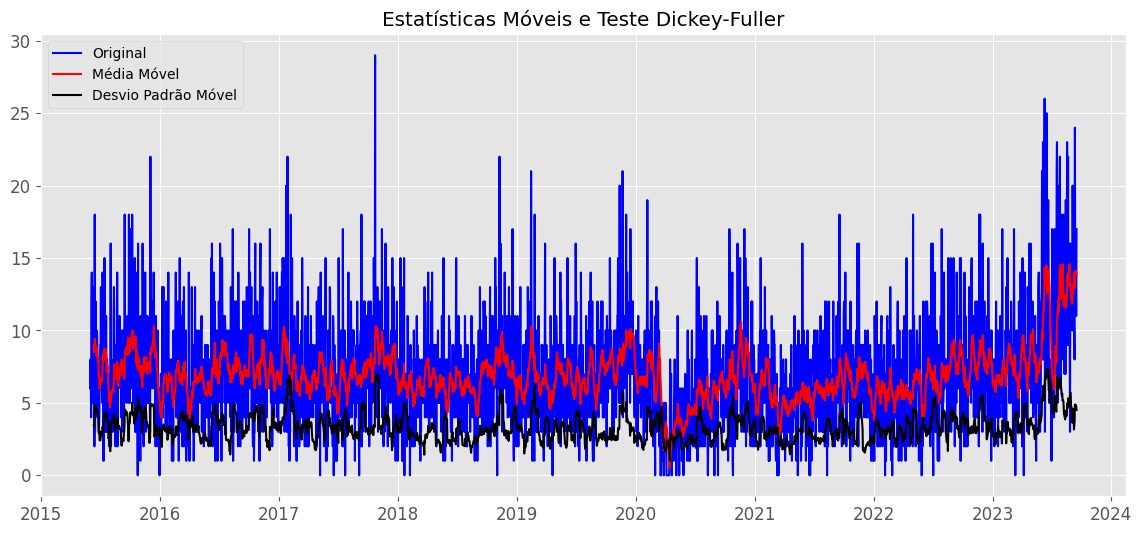


Resultado do Teste Dickey-Fuller:
Estatística do Teste              -4.239119
Valor-p                            0.000565
Número de Lags Consideradas       27.000000
Número de Observações Usadas    3002.000000
Valor Crítico (1%)                -3.432530
Valor Crítico (5%)                -2.862503
Valor Crítico (10%)               -2.567283
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [17]:
dsa_testa_estacionaridade(df_treino)

## Forecasting - Modelagem Preditiva Para Séries Temporais

Criaremos alguns modelos para este problema que temos em mãos, aumentando o grau de complexidade a cada versão.

A primeira versão será a mais simples possível, que usaremos como benchmark.

### Implementando a Estratégia 1 de Forecasting - Método Naive

Técnica de estimativa na qual os dados reais do último período são usados como previsão desse período, sem ajustá-los ou tentar estabelecer fatores causais. É usado apenas para comparação com as previsões geradas pelas melhores técnicas (sofisticadas).

Naive = ingênuo

Não há técnica avançada aqui e apenas usamos como ponto de partida. Qualquer modelo mais avançado deve apresentar resultados superiores ao Método Naive.

In [18]:
# Criamos um array com os valores da variável target em treino
array_qtd_acidentes_treino = np.asarray(df_treino.qtd_acidentes)

In [19]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
df_valid_cp = df_valid.copy()

In [20]:
# Previsão. Sim, isso é o Método Naive!
df_valid_cp['previsao_naive'] = array_qtd_acidentes_treino[len(array_qtd_acidentes_treino) - 1] 

In [21]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp.head()

,qtd_acidentes,previsao_naive
2023-09-17,7,17
2023-09-18,25,17
2023-09-19,18,17
2023-09-20,16,17
2023-09-21,16,17


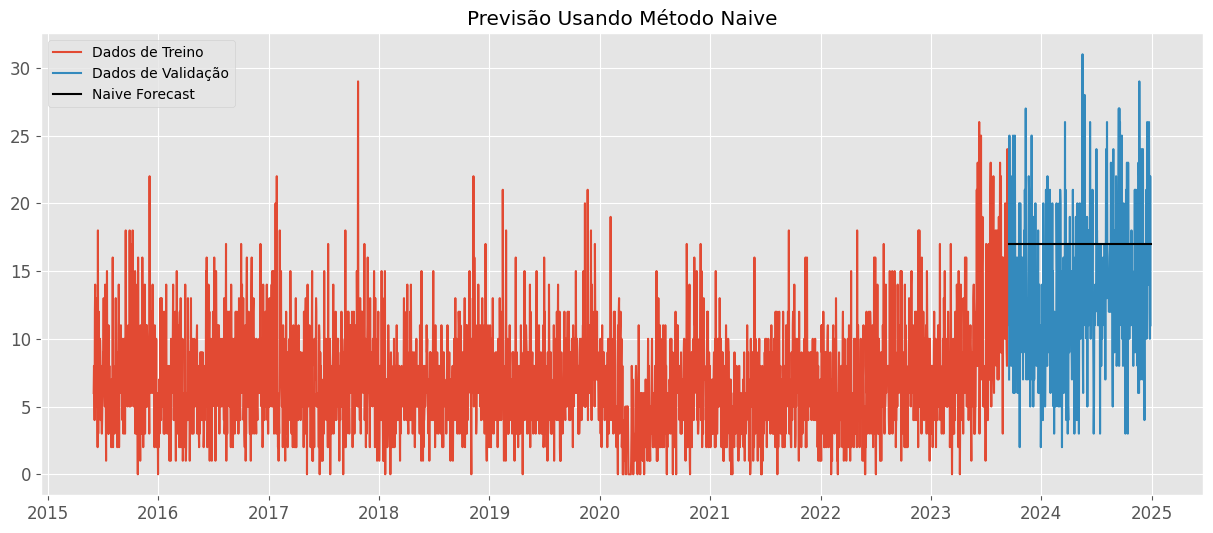

In [22]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(df_treino.index, df_treino['qtd_acidentes'], label = 'Dados de Treino') 
plt.plot(df_valid.index, df_valid['qtd_acidentes'], label = 'Dados de Validação') 
plt.plot(df_valid_cp.index, df_valid_cp['previsao_naive'], label = 'Naive Forecast',color='black') 
plt.legend(loc = 'best') 
plt.show()

Observe que a linha amarela segue uma linha horizontal, sem considerar o padrão de comportamento da série ao longo do tempo. 

Ou seja, a previsão seria apenas um valor geral considerando o último valor dos dados de treino (dados históricos).

Esse é um método muito simples, mas que serve como ponto de partida. Qualquer técnica mais avançada deve apresentar uma performance melhor.

In [23]:
# Define valor real e valor previsto
y_true = df_valid_cp.qtd_acidentes
y_pred = df_valid_cp.previsao_naive

In [24]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

6.253357307234275


### Implementando a Estratégia 2 de Forecasting - Exponential Smoothing

Exponential Smoothing é uma técnica de modelagem de séries temporais que utiliza uma média móvel ponderada para prever valores futuros de uma série temporal. Cada ponto de dado é atribuído com um peso exponencial decrescente, com os pontos mais recentes recebendo mais peso e os pontos mais antigos recebendo menos peso. O resultado é uma previsão suavizada que leva em consideração tanto a tendência geral quanto a sazonalidade da série temporal.

"Forecasting com Simple Exponential Smoothing (Suavização Exponencial Simples) é uma técnica de previsão de séries temporais que suaviza os dados para prever valores futuros.

Esta técnica é particularmente útil quando a série temporal não exibe tendências ou sazonalidade significativas, ou seja, quando a série é relativamente constante ao longo do tempo com variações aleatórias.

A ideia básica por trás do Simple Exponential Smoothing é que as previsões futuras são feitas com base em uma ponderação dos valores passados da série temporal.

O peso dado aos valores passados diminui exponencialmente à medida que nos movemos para trás no tempo, daí o nome 'suavização exponencial'.

O parâmetro chave nesta técnica é o fator de suavização α, que determina a rapidez com que o peso diminui. O α tem um valor entre 0 e 1, onde valores mais próximos de 1 dão mais peso aos dados mais recentes e valores mais próximos de 0 dão mais peso aos dados mais antigos."

In [25]:
# Versão 1 do modelo - Simple Exponential Smoothing
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html

# A função SimpleExpSmoothing() recebe os dados de treino no formato de array numpy
# A função fit() faz o treinamento

# O hiperparâmetro smoothing_level define o nível de suavização exponencial na série
# O hiperparâmetro optimized define se teremos ou não otimização 

# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(array_qtd_acidentes_treino).fit(smoothing_level = 0.2, optimized = True)

In [26]:
# Previsões com o Modelo
df_valid_cp = df_valid.copy()
df_valid_cp['previsoes_v1'] = modelo_v1.forecast(len(df_valid_cp)) 

In [27]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp.head()

,qtd_acidentes,previsoes_v1
2023-09-17,7,14.100329
2023-09-18,25,14.100329
2023-09-19,18,14.100329
2023-09-20,16,14.100329
2023-09-21,16,14.100329


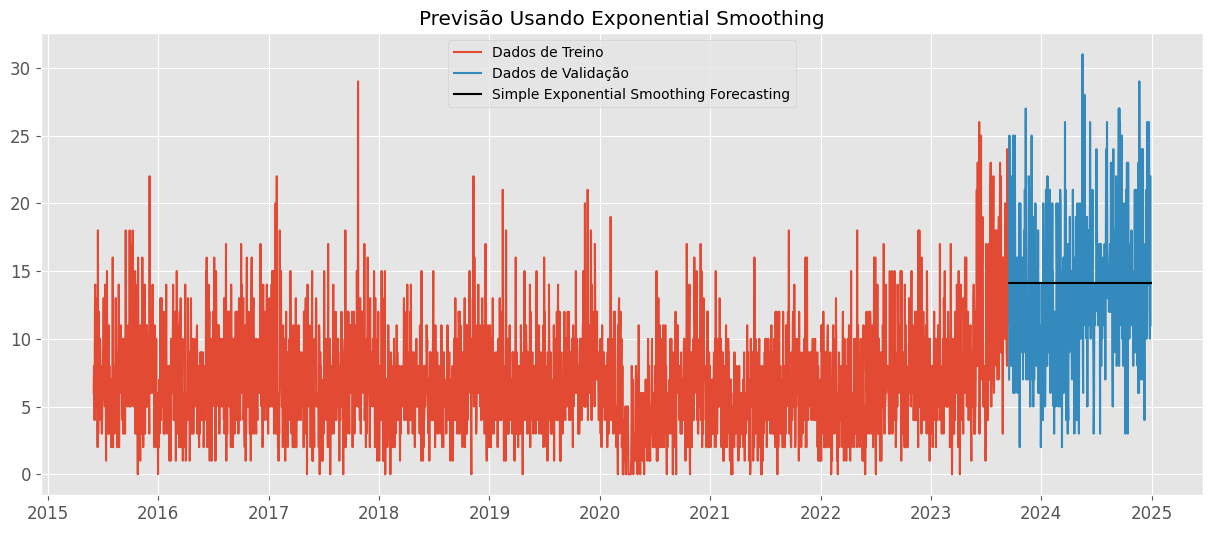

In [28]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['qtd_acidentes'], label = 'Dados de Treino')
plt.plot(df_valid_cp['qtd_acidentes'], label = 'Dados de Validação')
plt.plot(df_valid_cp['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting',color='black') 
plt.legend(loc = 'best') 
plt.show()

In [29]:
# Define valor real e valor previsto
y_true = df_valid_cp.qtd_acidentes
y_pred = df_valid_cp.previsoes_v1

In [30]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

5.328767369353858


### Implementando a Estratégia 3 de Forecasting - Double Exponential Smoothing 

**Forecasting com Double Exponential Smoothing (Suavização Exponencial Dupla)**

É uma técnica avançada de previsão para séries temporais que estende a Suavização Exponencial Simples para lidar com séries temporais que exibem tendências ao longo do tempo.

Essa técnica é particularmente útil quando os dados apresentam uma tendência ascendente ou descendente, mas sem sazonalidade significativa.

A Suavização Exponencial Dupla é realizada em duas etapas, incorporando um componente de suavização para os dados e um componente de suavização para a tendência.

Isso permite que a técnica capture tanto o nível atual da série temporal quanto a direção e velocidade da tendência. Como resultado, ela oferece previsões mais precisas para séries temporais com tendências do que a Suavização Exponencial Simples.

Os componentes principais da Suavização Exponencial Dupla são:

*   **Suavização do Nível:** A primeira etapa é semelhante à Suavização Exponencial Simples, onde o nível atual da série é suavizado. Isso ajuda a filtrar a variação aleatória dos dados.

*   **Suavização da Tendência:** A segunda etapa suaviza a tendência dos dados, permitindo que a técnica ajuste-se às mudanças na direção e velocidade da tendência ao longo do tempo.

In [31]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como não temos sazonalidade na série, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(df_treino['qtd_acidentes']), 
                                 trend = 'additive').fit(smoothing_level = 0.9, 
                                                         optimized = True) 

In [32]:
# Previsões com o Modelo
df_valid_cp.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(df_valid_cp))

In [33]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp.head()

,qtd_acidentes,previsoes_v1,previsoes_v2
2023-09-17,7,14.100329,16.433751
2023-09-18,25,14.100329,16.437133
2023-09-19,18,14.100329,16.440515
2023-09-20,16,14.100329,16.443896
2023-09-21,16,14.100329,16.447278


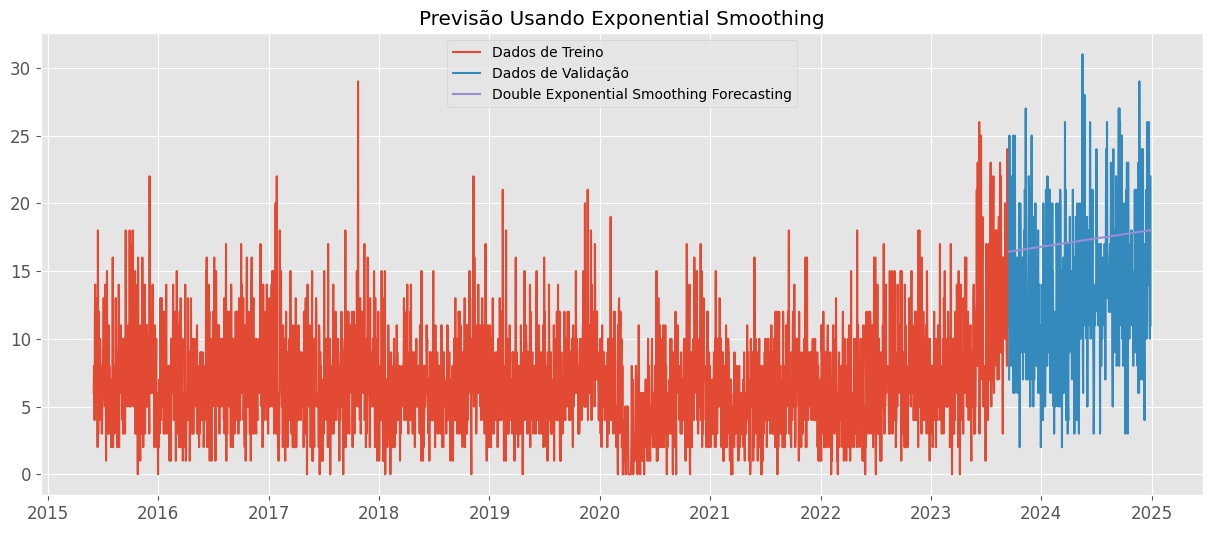

In [34]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['qtd_acidentes'], label = 'Dados de Treino')
plt.plot(df_valid_cp['qtd_acidentes'], label = 'Dados de Validação')
plt.plot(df_valid_cp['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [35]:
# Define valor real e valor previsto
y_true = df_valid_cp.qtd_acidentes
y_pred = df_valid_cp.previsoes_v2

In [36]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

6.335947393658047


## Forecasting - Modelagem Preditiva Para Séries Temporais

Em Estatística e Econometria, e em particular na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA). 

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade. 

A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez). O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

### Implementando a Estratégia 4 de Forecasting - Double Exponential Smoothing 

O Forecasting com o modelo ARIMA, que significa Modelo Autoregressivo Integrado de Médias Móveis, é uma das técnicas mais utilizadas para a previsão de séries temporais.

O ARIMA é particularmente útil para séries temporais que mostram padrões claros de tendências e/ou sazonalidade, e é capaz de modelar uma ampla gama de sequências de dados temporais.

O modelo ARIMA combina três componentes básicos: Autoregressivo (AR), Diferenciação Integrada (I), e Médias Móveis (MA):

Autoregressivo (AR): Este componente modela a dependência entre uma observação e um número de observações defasadas (ou atrasadas). Em outras palavras, ele tenta explicar o momento atual em função de seus valores anteriores. O termo p representa a ordem do componente autoregressivo, indicando quantas observações passadas são usadas na modelagem.

Diferenciação Integrada (I): A diferenciação é usada para tornar a série temporal estacionária, ou seja, para garantir que suas propriedades estatísticas, como a média e a variância, sejam constantes ao longo do tempo. Isso é necessário porque os modelos ARIMA requerem que a série temporal seja estacionária. O termo d representa a ordem de diferenciação, ou quantas vezes a série de dados precisa ser diferenciada para alcançar a estacionariedade.

Médias Móveis (MA): Este componente modela o erro da previsão como uma combinação linear de erros de previsão passados. Em termos simples, ele tenta capturar a relação entre uma observação e um erro residual de previsões passadas. O termo q representa a ordem do componente de médias móveis, indicando o número de termos de erro passado incluídos no modelo.

Um modelo ARIMA é geralmente denotado como ARIMA(p,d,q), onde:

p é a ordem do componente autoregressivo,
d é a ordem de diferenciação,
q é a ordem do componente de médias móveis.

A seleção adequada dos parâmetros p, d, e q é essencial para o desempenho do modelo ARIMA. Métodos como o Critério de Informação de Akaike (AIC) ou o Critério de Informação Bayesiano (BIC) são frequentemente usados para comparar modelos com diferentes configurações de parâmetros e selecionar o melhor ajuste com base nos dados disponíveis.

O modelo ARIMA é amplamente aplicado em economia, finanças, meteorologia e em muitos outros campos para previsão de séries temporais. Sua flexibilidade e capacidade de modelar diversos comportamentos de séries temporais fazem dele uma ferramenta essencial na caixa de ferramentas de analistas e pesquisadores.

Para séries temporais com padrões sazonais claros, uma variação do ARIMA, conhecida como SARIMA (Sazonal ARIMA), é frequentemente utilizada, pois inclui termos adicionais para modelar a sazonalidade.

In [37]:
# Aplicando transformação de log (colocando os dados na mesma escala, o que é requerido pelos modelos ARIMA)
df_treino_log = np.log(df_treino['qtd_acidentes']+1) 

In [38]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino_log, order = (2, 1, 0), freq = 'D')

In [39]:
# Treinamento
modelo_v3 = modelo_AR.fit()  

In [40]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v3 = modelo_v3.fittedvalues

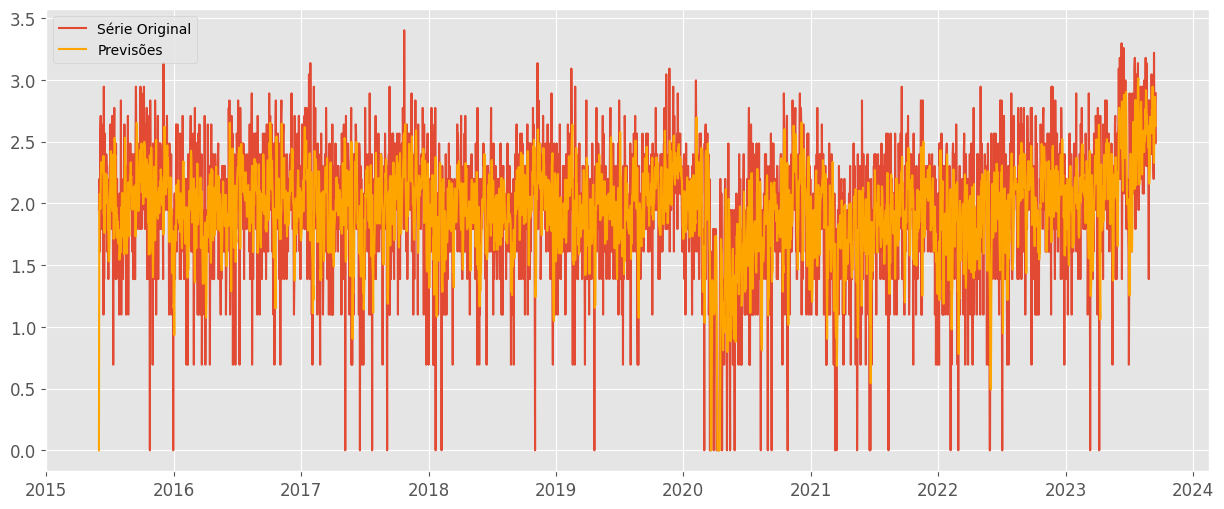

In [41]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v3, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [42]:
# Sumário do Modelo 
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          qtd_acidentes   No. Observations:                 3030
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2564.856
Date:                Wed, 17 Sep 2025   AIC                           5135.713
Time:                        00:41:29   BIC                           5153.761
Sample:                    06-01-2015   HQIC                          5142.201
                         - 09-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6451      0.016    -40.768      0.000      -0.676      -0.614
ar.L2         -0.3422      0.016    -21.174      0.000      -0.374      -0.311
sigma2         0.3184      0.007     46.075      0.000       0.305       0.332
===================================================================================
Ljung-Box (L1) (Q):                  17.60   Jarque-Bera (JB):               201.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.48
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Aqui está uma interpretação dos resultados:

Modelo: ARIMA(2,1,0) indica que o modelo é um processo autorregressivo de segunda ordem (AR(2)) com uma diferenciação (I(1)) e sem parte de médias móveis (MA(0)).

Parâmetros AR:

- ar.L1: O coeficiente do primeiro termo autorregressivo é -0.3419, o que significa que há uma relação negativa entre o valor atual da série e o valor imediatamente anterior.
- ar.L2: O coeficiente do segundo termo autorregressivo é -0.0695, indicando uma relação negativa mais fraca com o segundo valor anterior.
- Variância do erro (sigma2): O valor de 0.1610 indica a variância dos erros do modelo. Quanto menor esse valor, melhor o ajuste do modelo aos dados.

Testes Estatísticos:

- Ljung-Box (Q): O teste Ljung-Box verifica a autocorrelação residual. Um valor de p (Prob(Q)) próximo de 1, como 0.95 aqui, sugere que não há evidências significativas de autocorrelação residual, indicando um bom ajuste do modelo.
- Jarque-Bera (JB): Este teste verifica a normalidade dos resíduos. Um valor de p (Prob(JB)) próximo de 0, como aqui, indica que os resíduos não são normalmente distribuídos. Isso pode ser uma preocupação e pode valer a pena investigar mais.
- Heteroskedasticity (H): Este teste verifica a homocedasticidade dos resíduos. Um valor de p (Prob(H)) próximo de 0 indica que há evidências de heterocedasticidade, o que significa que a variância dos resíduos não é constante ao longo do tempo.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 16244.711. Um valor menor indica um melhor ajuste do modelo, mas é usado principalmente para comparar modelos.
- BIC (Bayesian Information Criterion): 16267.763. Assim como o AIC, um valor menor indica um melhor ajuste e é usado para comparações entre modelos.
- HQIC (Hannan-Quinn Information Criterion): 16252.334. Mais uma medida para comparar modelos, com um valor menor indicando um melhor ajuste.

O modelo ARIMA(2,1,0) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. Isso pode afetar as previsões do modelo e a interpretação dos intervalos de confiança. Pode ser útil investigar transformações dos dados, adicionar variáveis exógenas ou considerar modelos alternativos para melhorar o ajuste.

In [43]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
df_valid_log = np.log(df_valid['qtd_acidentes']+1)

In [44]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v3 = modelo_v3.forecast(len(df_valid_log), alpha = 0.05) 

In [45]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v3 = modelo_v3.forecast(len(df_valid_log), alpha = 0.05) 

In [46]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes_v3, index = df_valid_log.index)

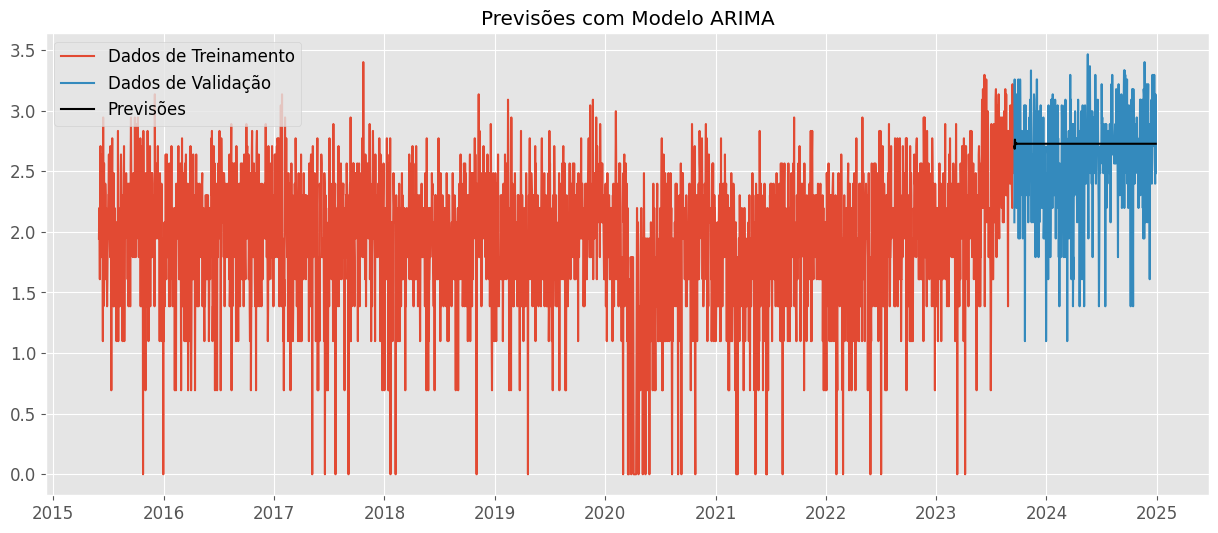

In [47]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões', color='black')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [48]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [49]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [50]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.42864957786575975


### Implementando a Estratégia 5 de Forecasting - Modelo SARIMAX

"O modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) é uma extensão do modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average), que por sua vez é uma extensão do ARIMA (AutoRegressive Integrated Moving Average).

Essa abordagem é usada para análise e previsão de séries temporais, adicionando a capacidade de incorporar variáveis exógenas (externas) e a sazonalidade na modelagem.

O núcleo do SARIMAX é o modelo SARIMA, que combina os componentes ARIMA para modelar tendências não sazonais e componentes sazonais específicos para lidar com padrões que se repetem em intervalos regulares.

Um modelo SARIMA é denotado por SARIMA(p, d, q)(P, D, Q)[S], onde:

*   **p,d,q** são os parâmetros ARIMA para a tendência não sazonal (autoregressivo, diferenciado, médias móveis).
*   **P,D,Q** são os parâmetros sazonais análogos aplicados aos componentes da série temporal que se repetem em intervalos de tempo S.
*   **S** é a periodicidade da sazonalidade.

O "X" em SARIMAX representa a inclusão de variáveis exógenas no modelo, o que é opcional, mas pode turbinar a performance do modelo.

Essas são variáveis externas que podem influenciar a série temporal que está sendo modelada, mas não são influenciadas por ela.

Por exemplo, em um modelo de previsão de vendas, além da sazonalidade e tendência das próprias vendas, fatores como atividades promocionais, feriados e condições econômicas podem ser incorporados como variáveis exógenas para melhorar a precisão da previsão.

O SARIMAX é particularmente útil em situações onde a série temporal é influenciada por fatores externos além de suas próprias dinâmicas internas.

Ao incorporar variáveis exógenas, o modelo pode capturar efeitos que não seriam explicados apenas pelos componentes autoregressivos, de médias móveis e sazonais. Isso torna o SARIMAX uma ferramenta poderosa para previsões mais precisas em contextos complexos.

Por exemplo, no planejamento de demanda de produtos, fatores como campanhas de marketing, mudanças de preços ou eventos especiais podem ser modelados como variáveis exógenas.

Isso permite que as empresas ajustem melhor seus estoques e operações às expectativas futuras de demanda.

A implementação do SARIMAX geralmente envolve as seguintes etapas:

Análise Exploratória: Examinar a série temporal para entender suas características, incluindo tendências, sazonalidade e possíveis variáveis exógenas.
Estacionaridade: Garantir que a série temporal seja estacionária, aplicando diferenciação se necessário.
Seleção de Parâmetros: Usar critérios como o AIC (Critério de Informação de Akaike) para selecionar os melhores parâmetros para o modelo.
Incorporação de Variáveis Exógenas: Incluir dados externos relevantes ao modelo.
Ajuste do Modelo: Usar os dados históricos para treinar o modelo SARIMAX.
Previsão: Realizar previsões futuras com o modelo ajustado, levando em conta tanto as dinâmicas internas quanto as influências externas.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [51]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(df_treino_log, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

In [52]:
# Treinamento do modelo
modelo_v4 = modelo_SARIMAX.fit(disp = True)

In [53]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v4 = modelo_v4.fittedvalues

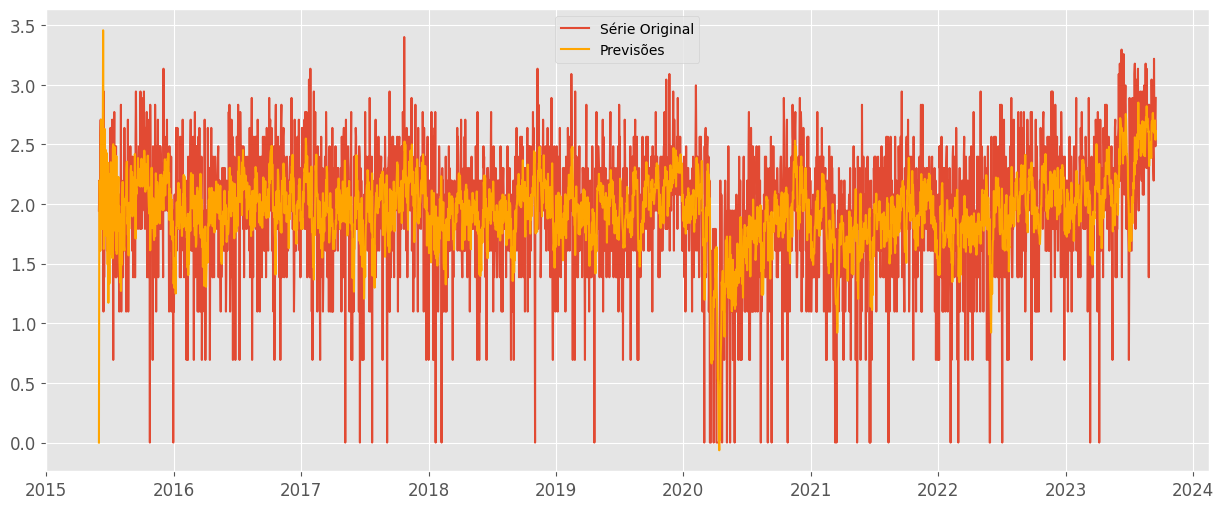

In [54]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [55]:
# Sumário do Modelo 
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        qtd_acidentes   No. Observations:                 3030
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -2370.568
Date:                              Wed, 17 Sep 2025   AIC                           4757.135
Time:                                      00:41:56   BIC                           4805.232
Sample:                                  06-01-2015   HQIC                          4774.430
                                       - 09-16-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8115      0.017    -48.945      0.000      -0.844      -0.779
ar.L2         -0.6761      0.021    -31.500      0.000      -0.718      -0.634
ar.L3         -0.5170      0.023    -22.102      0.000      -0.563      -0.471
ar.L4         -0.4084      0.024    -17.307      0.000      -0.455      -0.362
ar.L5         -0.2992      0.022    -13.372      0.000      -0.343      -0.255
ar.L6         -0.1773      0.017    -10.266      0.000      -0.211      -0.143
ma.S.L12      -0.9998      0.217     -4.603      0.000      -1.426      -0.574
sigma2         0.2756      0.060      4.624      0.000       0.159       0.392
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):               396.86
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.66
Prob(H) (two-sided):                  0.95   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Este modelo SARIMAX (Seasonal AutoRegressive Integrated Moving-Average with eXogenous variables) é um modelo de série temporal que inclui componentes sazonais. O modelo especificado é SARIMAX(6, 1, 0)x(0, 1, [1], 12), o que significa:

Parte não sazonal (ARIMA):

- AR(6): Processo autorregressivo de ordem 6.
- I(1): Diferenciação de primeira ordem.
- MA(0): Sem parte de médias móveis.

Parte sazonal:

- SAR(0): Sem componente autorregressivo sazonal.
- SI(1): Diferenciação sazonal de ordem 1.
- SMA(1): Média móvel sazonal de ordem 1.
- Período sazonal: 12 (indicando sazonalidade anual, presumivelmente mensal).

Aqui está uma interpretação dos resultados:

- Parâmetros AR: Os coeficientes dos termos autorregressivos (ar.L1 a ar.L6) mostram a relação entre o valor atual da série e seus valores anteriores. Por exemplo, o coeficiente ar.L1 é -0.8115, indicando uma relação negativa forte com o valor anterior.

- Parâmetro MA sazonal (ma.S.L12): O coeficiente de -0.9998 é muito próximo de -1, indicando uma forte relação negativa com o erro do termo sazonal anterior.

- Variância do erro (sigma2): O valor de 0.2757 indica a variância dos erros do modelo.

Testes Estatísticos:

- Ljung-Box (Q): Um valor de p (Prob(Q)) próximo de 1, como 1.30 aqui, sugere que não há evidências significativas de autocorrelação residual.
- Jarque-Bera (JB): Um valor de p (Prob(JB)) 0 indica que os resíduos não são normalmente distribuídos.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 4757.135. Usado para comparar modelos, com um valor menor indicando um melhor ajuste.
- BIC (Bayesian Information Criterion): 4805.231. Semelhante ao AIC, um valor menor indica um melhor ajuste.
- HQIC (Hannan-Quinn Information Criterion): 4774.430. Outra medida para comparar modelos.

O modelo SARIMAX(6,1,0)x(0,1,[1],12) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. A forte componente de média móvel sazonal indica uma relação significativa com os erros sazonais anteriores. Seria útil investigar a transformação dos dados ou a inclusão de variáveis exógenas para melhorar a normalidade dos resíduos e a homocedasticidade.

In [56]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v4 = modelo_v4.forecast(len(df_valid_log), alpha = 0.05) 

In [57]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v4, index = df_valid_log.index)

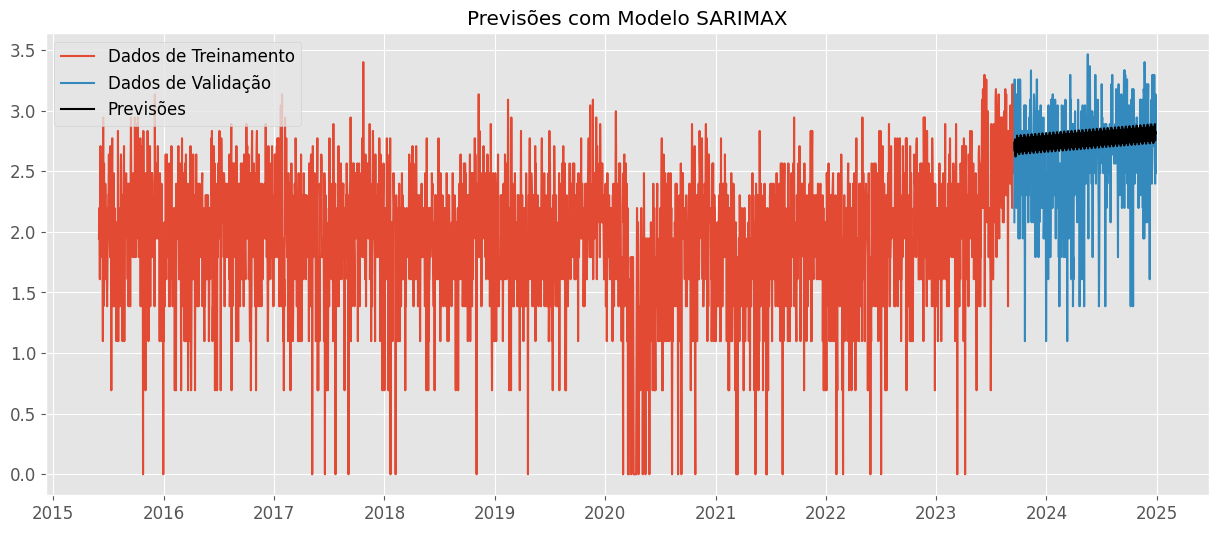

In [58]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões',color='black')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [59]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [60]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [61]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.4379864081352469


In [62]:
# Vamos fazer a previsão para uma janela de 30 horas
previsoes = modelo_v4.predict(start = novos_dados.index[0], 
                              end = novos_dados.index[30], 
                              dynamic = False)

In [63]:
previsoes

2024-12-29    2.780428
2024-12-30    2.792759
2024-12-31    2.867454
2025-01-01    2.735520
2025-01-02    2.844552
2025-01-03    2.819838
2025-01-04    2.798883
2025-01-05    2.778917
2025-01-06    2.892080
2025-01-07    2.757172
2025-01-08    2.830997
2025-01-09    2.820433
2025-01-10    2.782892
2025-01-11    2.795223
2025-01-12    2.869918
2025-01-13    2.737984
2025-01-14    2.847016
2025-01-15    2.822302
2025-01-16    2.801347
2025-01-17    2.781381
2025-01-18    2.894544
2025-01-19    2.759636
2025-01-20    2.833461
2025-01-21    2.822896
2025-01-22    2.785355
2025-01-23    2.797687
2025-01-24    2.872381
2025-01-25    2.740447
2025-01-26    2.849480
2025-01-27    2.824765
2025-01-28    2.803810
Freq: D, Name: predicted_mean, dtype: float64

In [64]:
# Inversa da transformação de log
np.exp(previsoes[0:])

2024-12-29    16.125921
2024-12-30    16.326008
2024-12-31    17.592171
2025-01-01    15.417762
2025-01-02    17.193862
2025-01-03    16.774138
2025-01-04    16.426293
2025-01-05    16.101574
2025-01-06    18.030783
2025-01-07    15.755230
2025-01-08    16.962367
2025-01-09    16.784109
2025-01-10    16.165697
2025-01-11    16.366278
2025-01-12    17.635564
2025-01-13    15.455791
2025-01-14    17.236272
2025-01-15    16.815513
2025-01-16    16.466810
2025-01-17    16.141290
2025-01-18    18.075257
2025-01-19    15.794092
2025-01-20    17.004206
2025-01-21    16.825508
2025-01-22    16.205571
2025-01-23    16.406647
2025-01-24    17.679063
2025-01-25    15.493914
2025-01-26    17.278787
2025-01-27    16.856990
2025-01-28    16.507427
Freq: D, Name: predicted_mean, dtype: float64

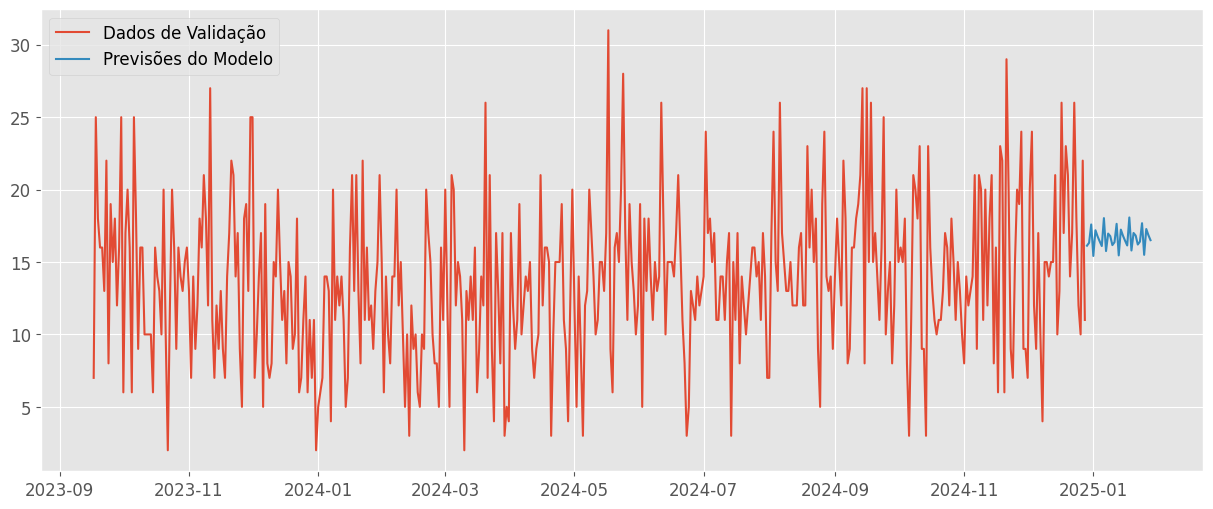

In [65]:
# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid, label = 'Dados de Validação')
plt.plot(np.exp(previsoes[0:]), label = 'Previsões do Modelo')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [66]:
# Buscar as últimas 120 dias dos dados de validação
df_valid_ultimos_120_dias = df_valid.tail(120)

In [67]:
df_valid_ultimos_120_dias

,qtd_acidentes
2024-08-31,9
2024-09-01,14
2024-09-02,18
2024-09-03,15
2024-09-04,12
...,...
2024-12-24,18
2024-12-25,12
2024-12-26,10
2024-12-27,22


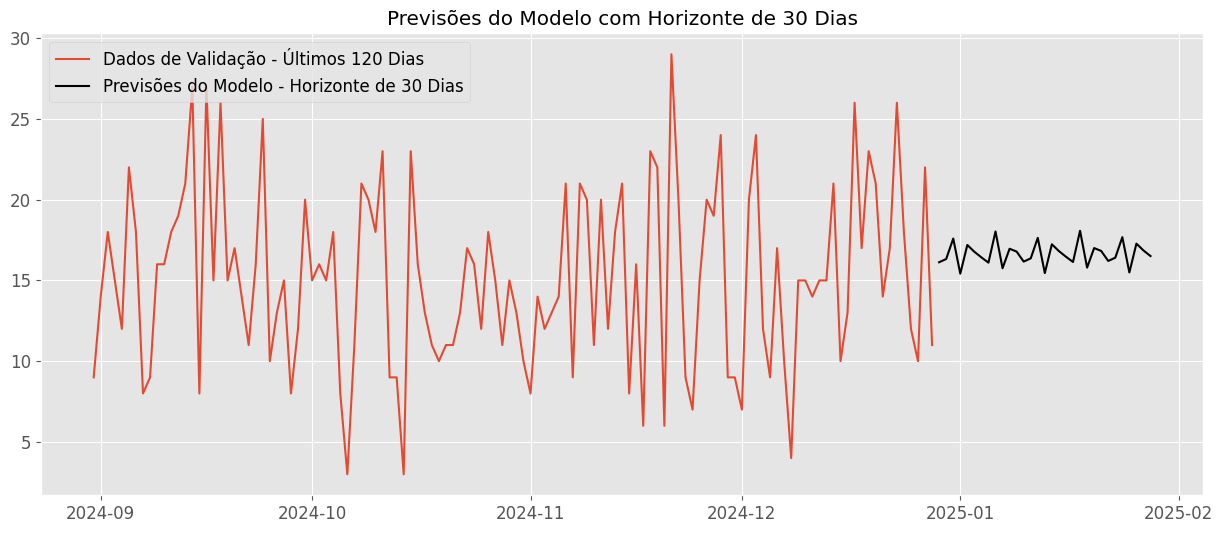

In [68]:
# Criamos uma nova série para as previsões com o índice correto
# O índice deve começar imediatamente após o último índice de df_valid_ultimos_120_dias
inicio_previsoes = df_valid_ultimos_120_dias.index[-1] + pd.Timedelta(days = 1)
indice_previsoes = pd.date_range(start = inicio_previsoes, periods = len(previsoes[0:]), freq = 'D')
previsoes_series = pd.Series(np.exp(previsoes[0:]), index = indice_previsoes)

# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid_ultimos_120_dias, label = 'Dados de Validação - Últimos 120 Dias')
plt.plot(previsoes_series, label='Previsões do Modelo - Horizonte de 30 Dias',color='black')
plt.title('Previsões do Modelo com Horizonte de 30 Dias')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show();